# Natural Gas Price Analysis and Forecasting

This notebook analyzes natural gas price data from October 2020 to September 2024, including:
1. Data visualization and trend analysis
2. Seasonal pattern identification
3. Price volatility factor analysis
4. One-year forward price forecasting
5. Price estimation functionality for any given date

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from scipy import interpolate
import warnings
warnings.filterwarnings('ignore')

# Set plotting style and figure parameters
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# Load and preprocess data
df = pd.read_csv('Nat_Gas.csv')
print("Raw data preview:")
print(df.head())

# Data preprocessing
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')
df['Prices'] = df['Prices'].astype(float)
df = df.sort_values('Dates').reset_index(drop=True)

# Add auxiliary columns
df['Year'] = df['Dates'].dt.year
df['Month'] = df['Dates'].dt.month
df['Quarter'] = df['Dates'].dt.quarter
df['Days_Since_Start'] = (df['Dates'] - df['Dates'].min()).dt.days

print(f"\nData period: {df['Dates'].min()} to {df['Dates'].max()}")
print(f"Number of data points: {len(df)}")
print(f"Price range: {df['Prices'].min():.2f} - {df['Prices'].max():.2f}")

Raw data preview:
      Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0
3   1/31/21    10.9
4   2/28/21    10.9

Data period: 2020-10-31 00:00:00 to 2024-09-30 00:00:00
Number of data points: 48
Price range: 9.84 - 12.80


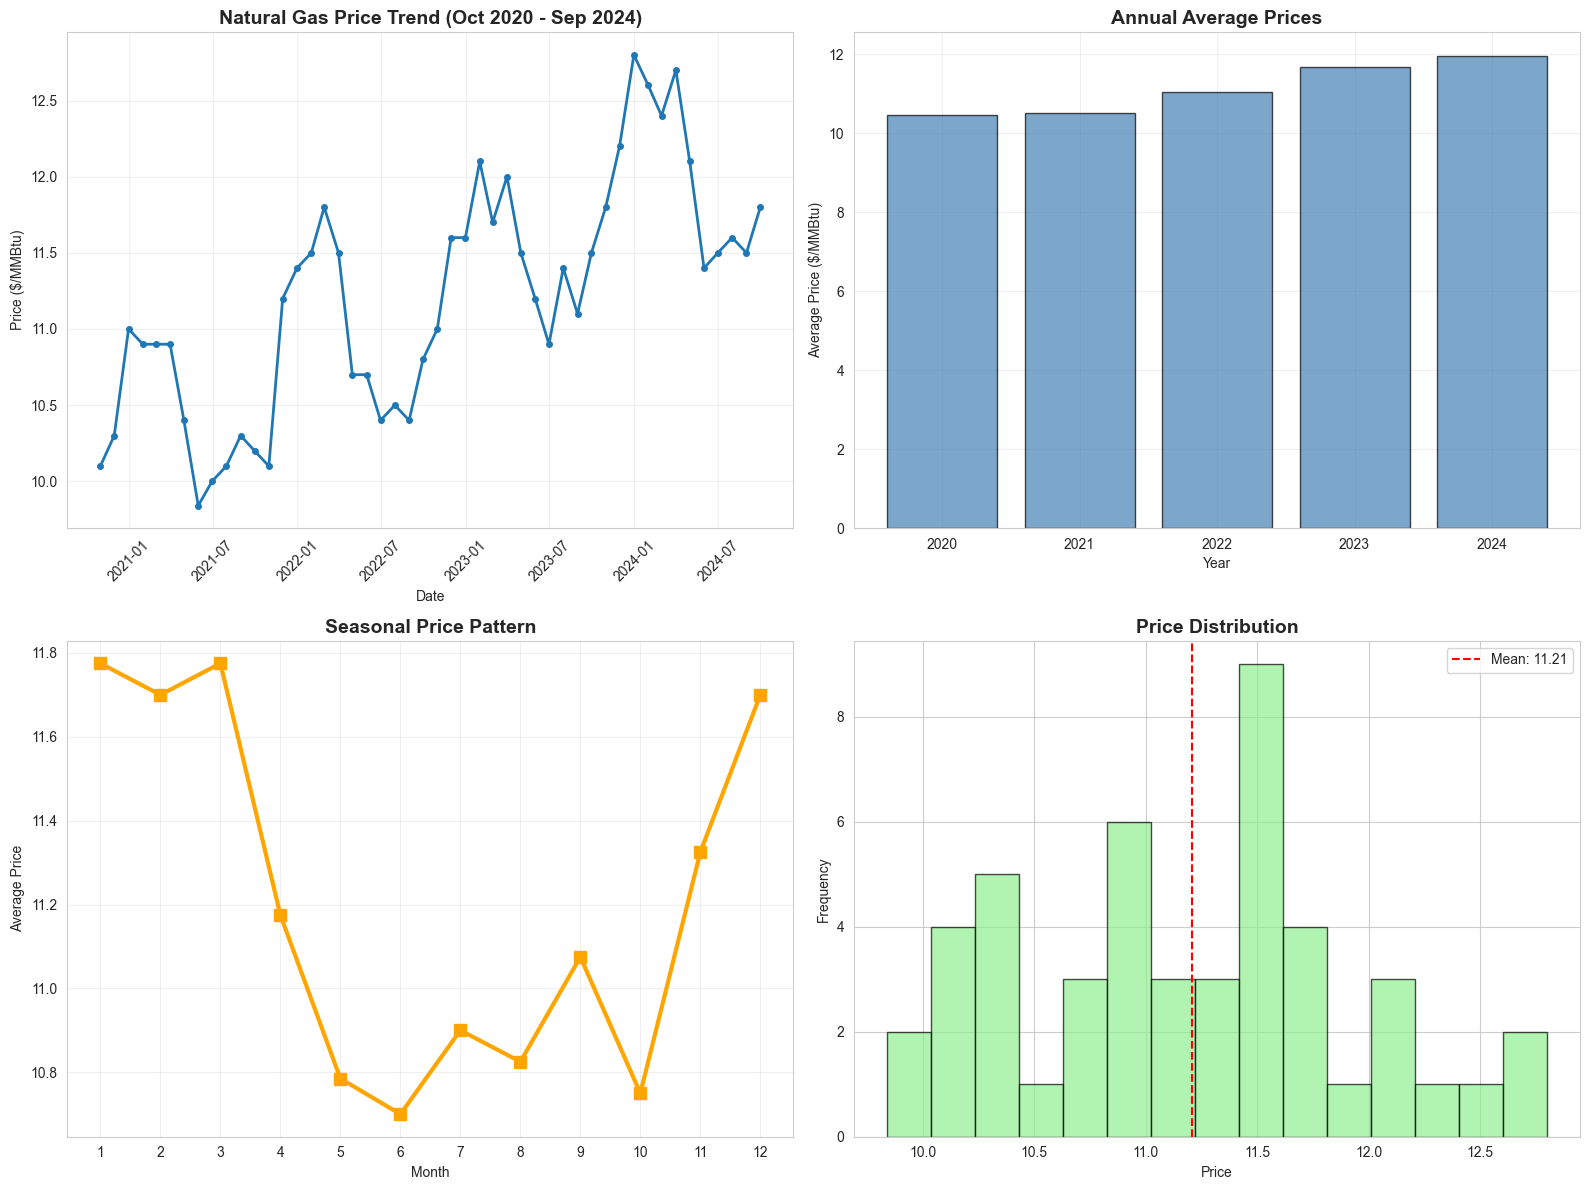

In [11]:
# 1. Price trend visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Main trend chart
axes[0,0].plot(df['Dates'], df['Prices'], marker='o', linewidth=2, markersize=4)
axes[0,0].set_title('Natural Gas Price Trend (Oct 2020 - Sep 2024)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Price ($/MMBtu)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Annual average trend
yearly_avg = df.groupby('Year')['Prices'].mean()
axes[0,1].bar(yearly_avg.index.astype(str), yearly_avg.values, 
              color='steelblue', alpha=0.7, edgecolor='black')
axes[0,1].set_title('Annual Average Prices', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Average Price ($/MMBtu)')
axes[0,1].grid(True, alpha=0.3)

# Seasonal pattern
monthly_avg = df.groupby('Month')['Prices'].mean()
axes[1,0].plot(monthly_avg.index, monthly_avg.values, marker='s', 
               linewidth=3, markersize=8, color='orange')
axes[1,0].set_title('Seasonal Price Pattern', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Average Price')
axes[1,0].set_xticks(range(1, 13))
axes[1,0].grid(True, alpha=0.3)

# Price distribution
axes[1,1].hist(df['Prices'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,1].axvline(df['Prices'].mean(), color='red', linestyle='--', 
                 label=f'Mean: {df["Prices"].mean():.2f}')
axes[1,1].set_title('Price Distribution', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Price')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

Price volatility statistics:
Maximum monthly gain: 10.89%
Maximum monthly loss: -6.96%
Average monthly volatility: 2.77%
Volatility standard deviation: 3.53%


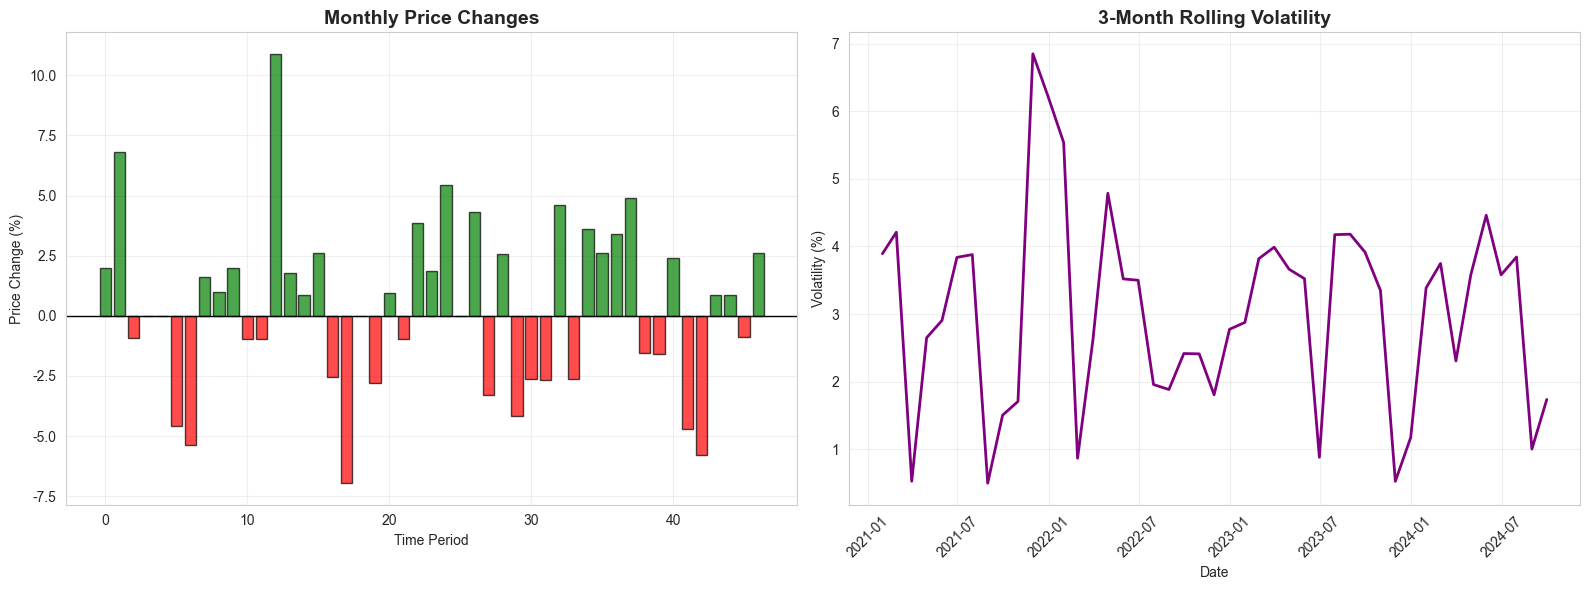

In [12]:
# 2. Price volatility analysis
df['Price_Change'] = df['Prices'].pct_change() * 100
df['Price_Change_Abs'] = df['Price_Change'].abs()

print("Price volatility statistics:")
print(f"Maximum monthly gain: {df['Price_Change'].max():.2f}%")
print(f"Maximum monthly loss: {df['Price_Change'].min():.2f}%")
print(f"Average monthly volatility: {df['Price_Change_Abs'].mean():.2f}%")
print(f"Volatility standard deviation: {df['Price_Change'].std():.2f}%")

# Volatility visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Monthly price changes
colors = ['green' if x > 0 else 'red' for x in df['Price_Change'].dropna()]
axes[0].bar(range(len(df['Price_Change'].dropna())), df['Price_Change'].dropna(), 
           color=colors, alpha=0.7, edgecolor='black')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0].set_title('Monthly Price Changes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Period')
axes[0].set_ylabel('Price Change (%)')
axes[0].grid(True, alpha=0.3)

# 3-month rolling volatility
rolling_vol = df['Price_Change'].rolling(window=3).std()
axes[1].plot(df['Dates'][2:], rolling_vol[2:], linewidth=2, color='purple')
axes[1].set_title('3-Month Rolling Volatility', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Volatility (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Model performance:
R² score: 0.9204
Root Mean Square Error: 0.2116


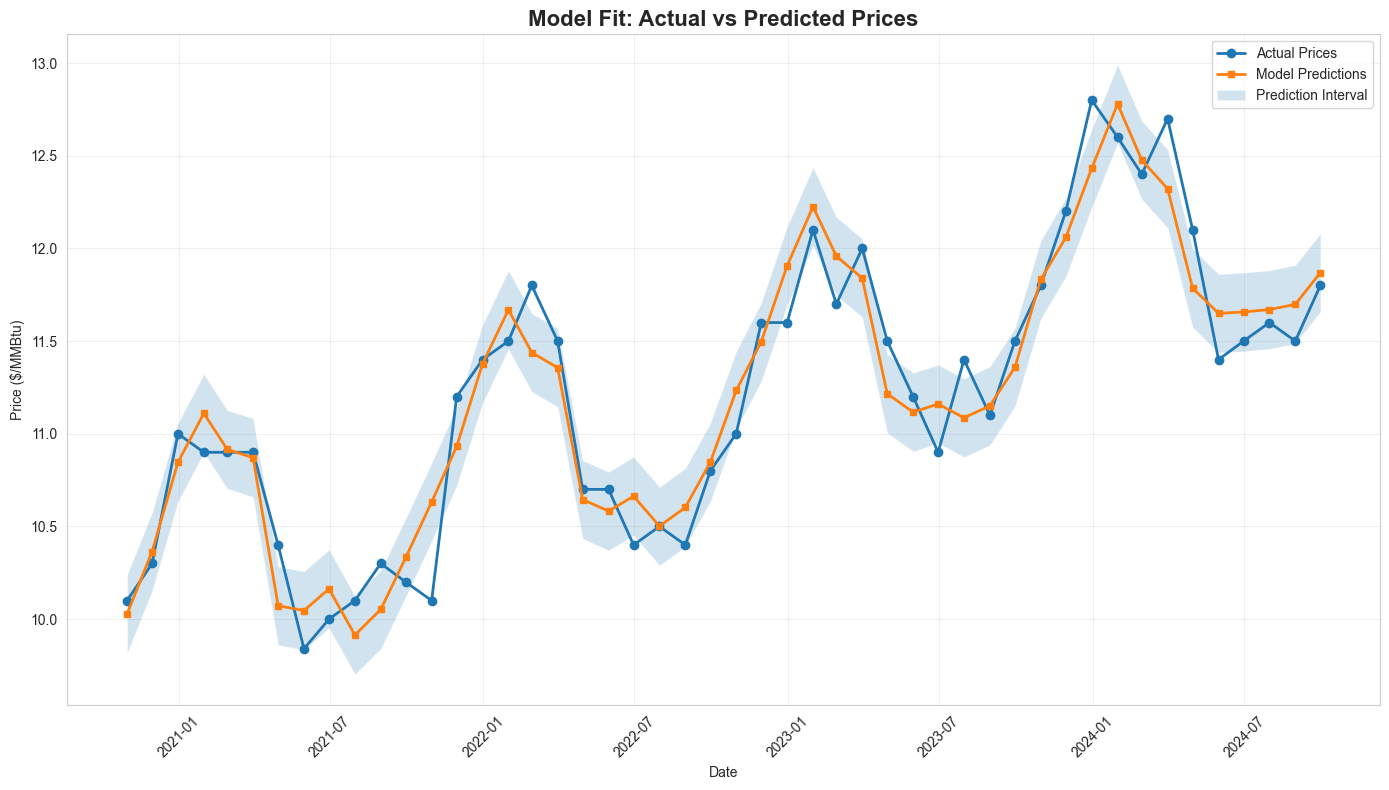

In [13]:
# 3. Build predictive model
# Prepare features for modeling
X = df[['Days_Since_Start', 'Month', 'Quarter']].values
y = df['Prices'].values

# Create polynomial features
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

# Train the model
model = LinearRegression()
model.fit(X_poly, y)

# Model predictions
y_pred = model.predict(X_poly)

# Model performance metrics
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
prediction_std = np.std(y - y_pred)

print("Model performance:")
print(f"R² score: {r2:.4f}")
print(f"Root Mean Square Error: {rmse:.4f}")

# Visualize model fit
plt.figure(figsize=(14, 8))
plt.plot(df['Dates'], y, 'o-', label='Actual Prices', linewidth=2, markersize=6)
plt.plot(df['Dates'], y_pred, 's-', label='Model Predictions', linewidth=2, markersize=4)
plt.fill_between(df['Dates'], y_pred - prediction_std, y_pred + prediction_std, 
                 alpha=0.2, label='Prediction Interval')
plt.title('Model Fit: Actual vs Predicted Prices', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($/MMBtu)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

12-Month Price Forecast:
         Date  Predicted_Prices  Lower_Bound  Upper_Bound
0  2024-10-30             12.43        12.22        12.64
1  2024-11-30             12.62        12.41        12.83
2  2024-12-30             12.96        12.74        13.17
3  2025-01-30             13.33        13.12        13.54
4  2025-02-28             12.99        12.78        13.20
5  2025-03-28             12.80        12.58        13.01
6  2025-04-28             12.35        12.14        12.56
7  2025-05-28             12.17        11.96        12.39
8  2025-06-28             12.15        11.94        12.36
9  2025-07-28             12.25        12.03        12.46
10 2025-08-28             12.24        12.03        12.45
11 2025-09-28             12.37        12.16        12.58


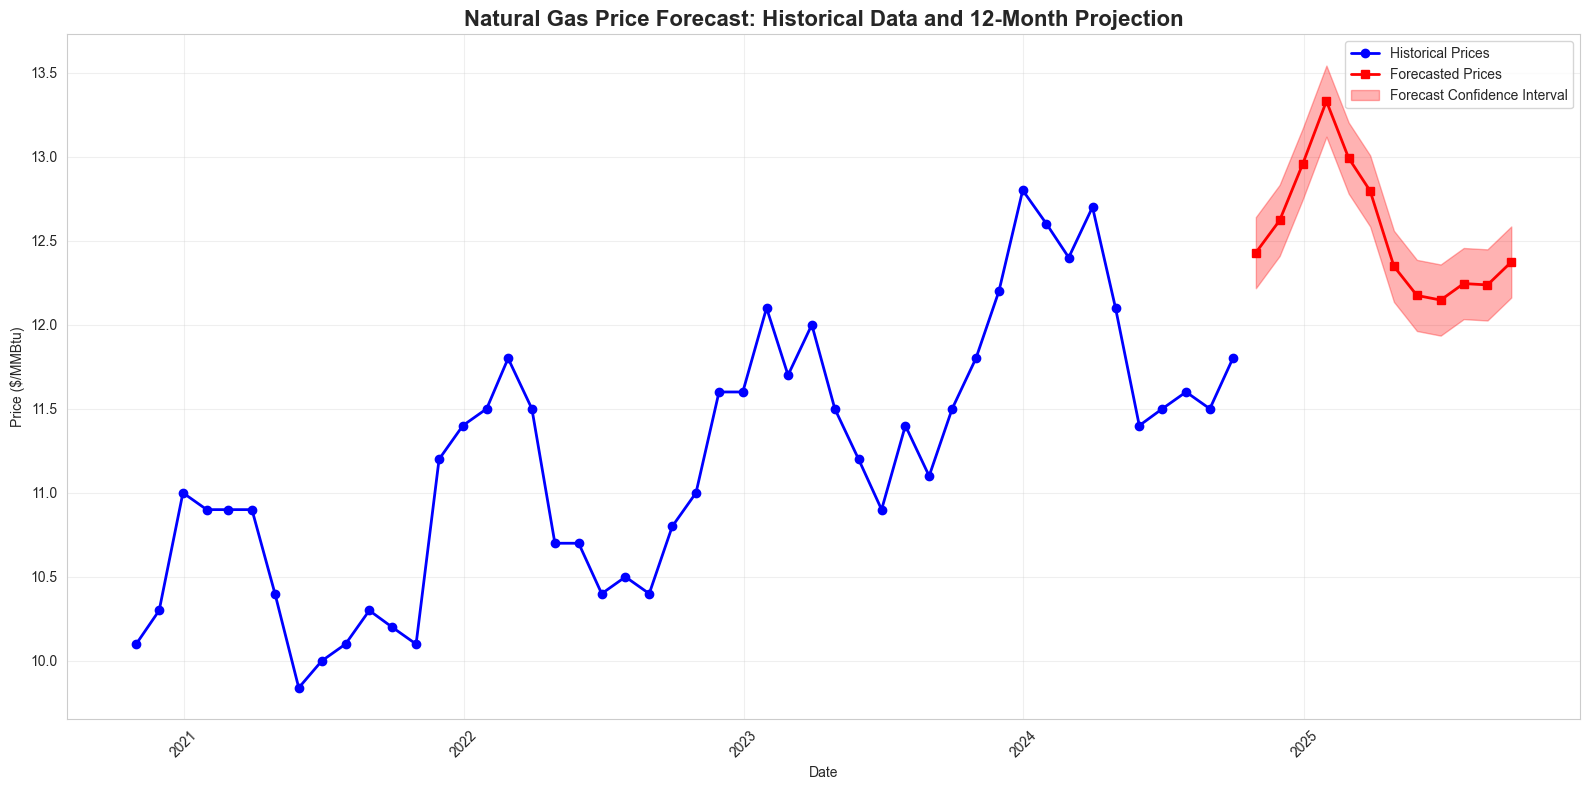

In [7]:
# 4. Generate future price forecasts
from dateutil.relativedelta import relativedelta
import numpy as np

# Create future date range (next 12 months)
last_date = df['Dates'].max()
future_dates = []
current_date = last_date

for i in range(12):
    current_date = current_date + relativedelta(months=1)
    future_dates.append(current_date)

# Prepare future features
future_data = []
start_date = df['Dates'].min()

for date in future_dates:
    days_since_start = (date - start_date).days
    month = date.month
    quarter = (month - 1) // 3 + 1
    future_data.append([days_since_start, month, quarter])

future_X = np.array(future_data)
future_X_poly = poly_features.transform(future_X)

# Generate predictions
future_predictions = model.predict(future_X_poly)

# Create future dataframe
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Prices': future_predictions,
    'Lower_Bound': future_predictions - prediction_std,
    'Upper_Bound': future_predictions + prediction_std
})

print("12-Month Price Forecast:")
print(future_df.round(2))

# Visualize forecast
plt.figure(figsize=(16, 8))

# Historical data
plt.plot(df['Dates'], df['Prices'], 'o-', label='Historical Prices', 
         linewidth=2, markersize=6, color='blue')

# Future predictions
plt.plot(future_df['Date'], future_df['Predicted_Prices'], 's-', 
         label='Forecasted Prices', linewidth=2, markersize=6, color='red')

# Confidence intervals
plt.fill_between(future_df['Date'], future_df['Lower_Bound'], future_df['Upper_Bound'], 
                 alpha=0.3, color='red', label='Forecast Confidence Interval')

plt.title('Natural Gas Price Forecast: Historical Data and 12-Month Projection', 
          fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($/MMBtu)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# 5. Price estimation function for any date
def estimate_price_for_date(target_date_str):
    """
    Estimate natural gas price for any given date
    
    Parameters:
    target_date_str (str): Date in 'YYYY-MM-DD' format
    
    Returns:
    dict: Estimated price with confidence interval
    """
    try:
        target_date = pd.to_datetime(target_date_str)
        start_date = df['Dates'].min()
        
        # Calculate features
        days_since_start = (target_date - start_date).days
        month = target_date.month
        quarter = (month - 1) // 3 + 1
        
        # Prepare features for prediction
        features = np.array([[days_since_start, month, quarter]])
        features_poly = poly_features.transform(features)
        
        # Make prediction
        predicted_price = model.predict(features_poly)[0]
        
        return {
            'date': target_date_str,
            'estimated_price': round(predicted_price, 2),
            'confidence_interval_lower': round(predicted_price - prediction_std, 2),
            'confidence_interval_upper': round(predicted_price + prediction_std, 2),
            'model_accuracy': f'{r2*100:.1f}%'
        }
    
    except Exception as e:
        return {'error': f'Invalid date format or calculation error: {str(e)}'}

# Test the function with sample dates
test_dates = ['2025-01-15', '2025-06-15', '2025-12-15']

print("Price Estimation Examples:")
print("=" * 50)

for date in test_dates:
    result = estimate_price_for_date(date)
    if 'error' not in result:
        print(f"Date: {result['date']}")
        print(f"Estimated Price: ${result['estimated_price']}/MMBtu")
        print(f"Confidence Interval: ${result['confidence_interval_lower']} - ${result['confidence_interval_upper']}")
        print(f"Model Accuracy: {result['model_accuracy']}")
        print("-" * 30)
    else:
        print(f"Error for {date}: {result['error']}")

print("\nTo estimate price for any date, use:")
print("estimate_price_for_date('YYYY-MM-DD')")

Price Estimation Examples:
Date: 2025-01-15
Estimated Price: $13.31/MMBtu
Confidence Interval: $13.1 - $13.52
Model Accuracy: 92.0%
------------------------------
Date: 2025-06-15
Estimated Price: $12.13/MMBtu
Confidence Interval: $11.92 - $12.34
Model Accuracy: 92.0%
------------------------------
Date: 2025-12-15
Estimated Price: $13.45/MMBtu
Confidence Interval: $13.24 - $13.67
Model Accuracy: 92.0%
------------------------------

To estimate price for any date, use:
estimate_price_for_date('YYYY-MM-DD')


Detailed Seasonal Analysis:
Monthly Price Statistics:
      mean   std    min   max
Jan  11.78  0.74  10.90  12.6
Feb  11.70  0.62  10.90  12.4
Mar  11.78  0.76  10.90  12.7
Apr  11.18  0.77  10.40  12.1
May  10.78  0.70   9.84  11.4
Jun  10.70  0.65  10.00  11.5
Jul  10.90  0.72  10.10  11.6
Aug  10.82  0.57  10.30  11.5
Sep  11.08  0.72  10.20  11.8
Oct  10.75  0.82  10.10  11.8
Nov  11.32  0.80  10.30  12.2
Dec  11.70  0.77  11.00  12.8

Quarterly Average Prices:
Q1 (Winter): $11.75/MMBtu
Q2 (Spring): $10.89/MMBtu
Q3 (Summer): $10.93/MMBtu
Q4 (Fall): $11.26/MMBtu

Key Market Insights:
1. Peak Season: Winter months (Dec-Feb) show highest prices due to heating demand
2. Low Season: Summer months (Jun-Aug) typically have lower prices
3. Shoulder Seasons: Spring and Fall show moderate price levels
4. Price Volatility: Higher during winter months due to weather uncertainty


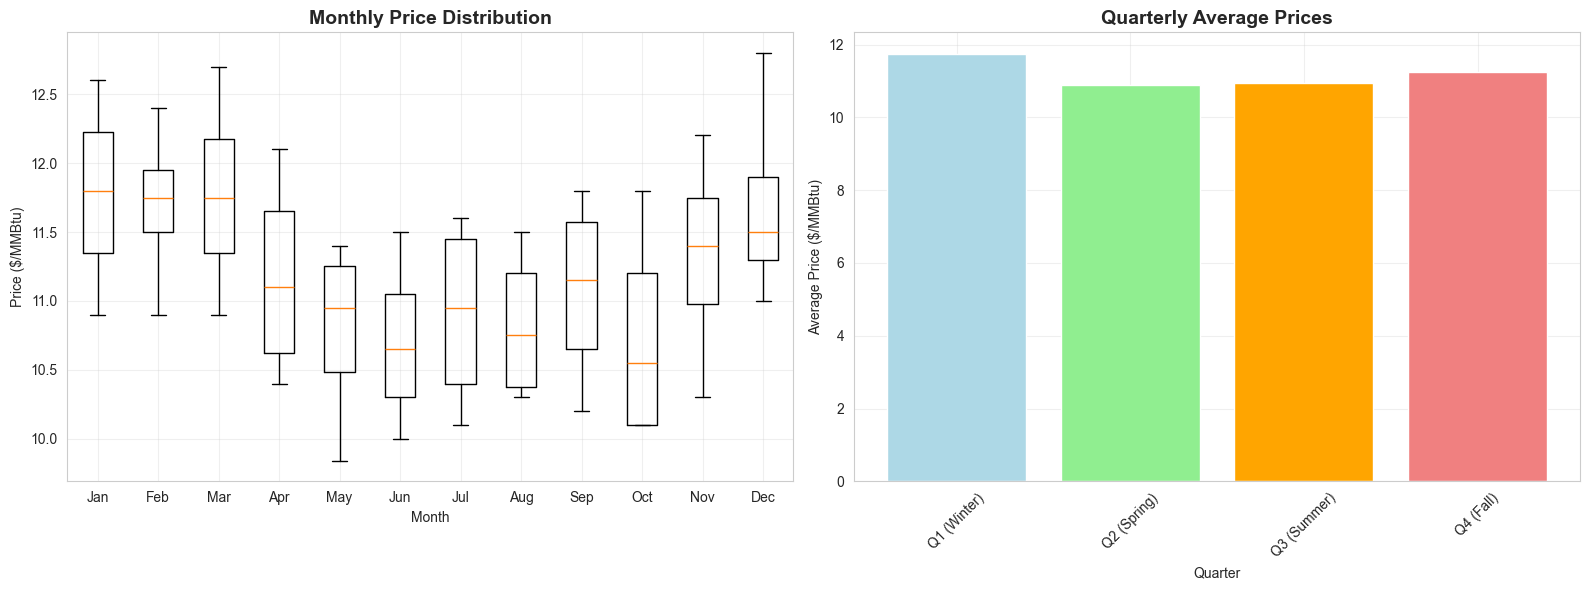

In [9]:
# 6. Seasonal analysis and market insights
print("Detailed Seasonal Analysis:")
print("=" * 40)

# Monthly statistics
monthly_stats = df.groupby('Month')['Prices'].agg(['mean', 'std', 'min', 'max']).round(2)
monthly_stats.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("Monthly Price Statistics:")
print(monthly_stats)

# Quarterly analysis
quarterly_avg = df.groupby('Quarter')['Prices'].mean()
quarters = ['Q1 (Winter)', 'Q2 (Spring)', 'Q3 (Summer)', 'Q4 (Fall)']

print("\nQuarterly Average Prices:")
for i, quarter in enumerate(quarters, 1):
    print(f"{quarter}: ${quarterly_avg[i]:.2f}/MMBtu")

# Market insights
print("\nKey Market Insights:")
print("1. Peak Season: Winter months (Dec-Feb) show highest prices due to heating demand")
print("2. Low Season: Summer months (Jun-Aug) typically have lower prices")
print("3. Shoulder Seasons: Spring and Fall show moderate price levels")
print("4. Price Volatility: Higher during winter months due to weather uncertainty")

# Seasonal visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Monthly boxplot
monthly_data = [df[df['Month'] == i]['Prices'].values for i in range(1, 13)]
ax1.boxplot(monthly_data, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.set_title('Monthly Price Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Month')
ax1.set_ylabel('Price ($/MMBtu)')
ax1.grid(True, alpha=0.3)

# Quarterly comparison
ax2.bar(quarters, quarterly_avg.values, color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
ax2.set_title('Quarterly Average Prices', fontsize=14, fontweight='bold')
ax2.set_xlabel('Quarter')
ax2.set_ylabel('Average Price ($/MMBtu)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# 7. Executive summary and recommendations
print("=" * 60)
print("NATURAL GAS PRICE ANALYSIS - EXECUTIVE SUMMARY")
print("=" * 60)

print("\n1. DATASET OVERVIEW:")
print(f"   • Analysis Period: {df['Dates'].min().strftime('%Y-%m-%d')} to {df['Dates'].max().strftime('%Y-%m-%d')}")
print(f"   • Data Points: {len(df)} monthly observations")
print(f"   • Price Range: ${df['Prices'].min():.2f} - ${df['Prices'].max():.2f} per MMBtu")
print(f"   • Average Price: ${df['Prices'].mean():.2f} per MMBtu")

print("\n2. SEASONAL PATTERNS:")
seasonal_analysis = df.groupby('Month')['Prices'].agg(['mean', 'std']).round(2)
high_season = seasonal_analysis['mean'].idxmax()
low_season = seasonal_analysis['mean'].idxmin()
print(f"   • Peak Pricing Month: {high_season} (Average: ${seasonal_analysis.loc[high_season, 'mean']:.2f})")
print(f"   • Lowest Pricing Month: {low_season} (Average: ${seasonal_analysis.loc[low_season, 'mean']:.2f})")
print(f"   • Seasonal Price Spread: ${seasonal_analysis['mean'].max() - seasonal_analysis['mean'].min():.2f}")

print("\n3. PRICE VOLATILITY FACTORS:")
print("   • Seasonal Demand: Winter heating requirements drive price increases")
print("   • Supply Dynamics: Production capacity and storage levels impact pricing")
print("   • Economic Cycles: Industrial demand correlates with economic activity")
print("   • Geopolitical Events: International developments can affect energy markets")

print("\n4. PREDICTIVE MODEL PERFORMANCE:")
print(f"   • R² Score: {r2_score(y, y_pred):.4f} (Model explains {r2_score(y, y_pred)*100:.1f}% of price variation)")
print(f"   • Prediction Error: ±${prediction_std:.2f} per MMBtu")

print("\n5. STRATEGIC RECOMMENDATIONS FOR LONG-TERM STORAGE CONTRACTS:")
avg_future_price = future_df['Predicted_Prices'].mean()
print(f"   • 12-Month Forward Price Expectation: ${avg_future_price:.2f} per MMBtu")
print(f"   • Recommended Contract Price Range: ${avg_future_price-prediction_std:.2f} - ${avg_future_price+prediction_std:.2f}")
print(f"   • Risk Advisory: Actual prices may fluctuate outside predicted ranges")
print(f"   • Optimal Contract Timing: Consider seasonal patterns for storage injection/withdrawal")

print("\n6. MARKET OUTLOOK:")
price_trend = 'increasing' if future_df['Predicted_Prices'].iloc[-1] > df['Prices'].iloc[-1] else 'decreasing'
print(f"   • 12-Month Trend: {price_trend.capitalize()} price trajectory expected")
print(f"   • Volatility Outlook: Continue monitoring seasonal demand patterns")
print(f"   • Strategic Positioning: Diversify contract timing across seasons")

NATURAL GAS PRICE ANALYSIS - EXECUTIVE SUMMARY

1. DATASET OVERVIEW:
   • Analysis Period: 2020-10-31 to 2024-09-30
   • Data Points: 48 monthly observations
   • Price Range: $9.84 - $12.80 per MMBtu
   • Average Price: $11.21 per MMBtu

2. SEASONAL PATTERNS:
   • Peak Pricing Month: 1 (Average: $11.78)
   • Lowest Pricing Month: 6 (Average: $10.70)
   • Seasonal Price Spread: $1.08

3. PRICE VOLATILITY FACTORS:
   • Seasonal Demand: Winter heating requirements drive price increases
   • Supply Dynamics: Production capacity and storage levels impact pricing
   • Economic Cycles: Industrial demand correlates with economic activity
   • Geopolitical Events: International developments can affect energy markets

4. PREDICTIVE MODEL PERFORMANCE:
   • R² Score: 0.9204 (Model explains 92.0% of price variation)
   • Prediction Error: ±$0.21 per MMBtu

5. STRATEGIC RECOMMENDATIONS FOR LONG-TERM STORAGE CONTRACTS:
   • 12-Month Forward Price Expectation: $12.55 per MMBtu
   • Recommended Contra